<a href="https://www.kaggle.com/code/nurulsakinah/predicting-used-car-prices-linear-rf-xgb?scriptVersionId=198845957" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction 
The goal is to predict the price of used cars based on various attributes

# 2. Import the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import re
import matplotlib.pyplot as plt
# ignore warning on infin
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# 3. Load the dataset


In [2]:
# read file
df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

# extraxt ids
test_ids = df_sub['id']

# 4. Exploratory Data Analysis

In [3]:
df.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900


In [4]:
def aggregate_info(df):
    ''' Calculate 
    count of unique, 
    unique values, 
    count & % of missing values, 
    data types of the columns '''
    nunique = df.nunique()
    unique = df.apply(lambda x: x.unique())
    missing_count = df.isna().sum()
    missing_percentage = round((df.isna().sum() / len(df)) * 100,2)
    dtypes = df.dtypes

    # combine metrics into a single DataFrame
    agg_df = pd.DataFrame({
        'nunique values': nunique,
        'unique': unique,
        'missing_count': missing_count,
        'missing_percentage': missing_percentage,
        'dtypes': dtypes
    })

    return agg_df

aggregate_info(df)

,nunique values,unique,missing_count,missing_percentage,dtypes
id,188533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.00,int64
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
model_year,34,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",0,0.00,int64
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,7,"[Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel,...",5083,2.70,object
engine,1117,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",0,0.00,object
transmission,52,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",0,0.00,object
ext_col,319,"[Yellow, Silver, Blue, Black, White, Snowflake...",0,0.00,object
int_col,156,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",0,0.00,object


For fuel type, we can probably fill this missing values based on the engine type. <br>
From the engine feature alone, we can extract other details about the car. <br>
We will create ne features: 'engine_hp','engine_liter','engine_cyl','engine_fuel' in Feature Engineering

In [5]:
# Summary of Numeric Features 

def numeric_summary(df):
    obs = df.shape[0]
    
    numeric_df = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': numeric_df.dtypes, 
        'Counts': numeric_df.apply(lambda x: x.count()), 
        'Nulls': numeric_df.apply(lambda x: x.isnull().sum()), 
        'NullPercent': (numeric_df.isnull().sum() / obs) * 100,
        'Mean' : numeric_df.mean(),
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Uniques': numeric_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': numeric_df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else '-')
    })
    
    return summary_df


numeric_summary(df)

,Dtype,Counts,Nulls,NullPercent,Mean,Min,Max,Uniques,UniqueValues
id,int64,188533,0,0.0,94266.000000,0,188532,188533,-
model_year,int64,188533,0,0.0,2015.829998,1974,2024,34,-
milage,int64,188533,0,0.0,65705.295174,100,405000,6651,-
price,int64,188533,0,0.0,43878.016178,2000,2954083,1569,-


Lets plot to see more details on each features

In [6]:
# get the categorical variables
categorical_col = df.select_dtypes(include='object').columns.tolist()
print(categorical_col)
# get continous variable
cont_col = df.select_dtypes(include=['int']).columns.tolist()
# print(cont_col)
# drop 'id'
cont_col.remove('id') 
print(cont_col)

['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
['model_year', 'milage', 'price']


## Data Visualisation
### Univariate Analysis
We will start by plotting the continuous features to see their distributions.

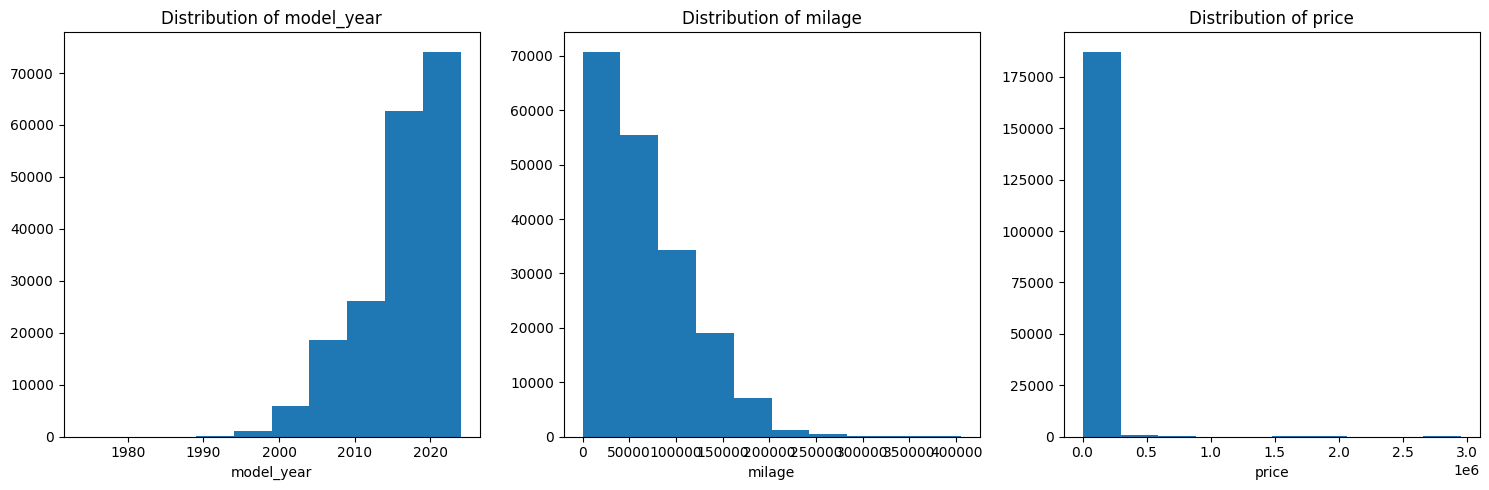

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns 

# plot histograms
for i, col in enumerate(cont_col):
    axs[i].hist(df[col])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

Univariate analysis for each categorical features

We can visually detect outliers using boxplots. From the boxplots, here are outliers in each of the continuous features, some deeper analysis would be needed before we handle these outliers

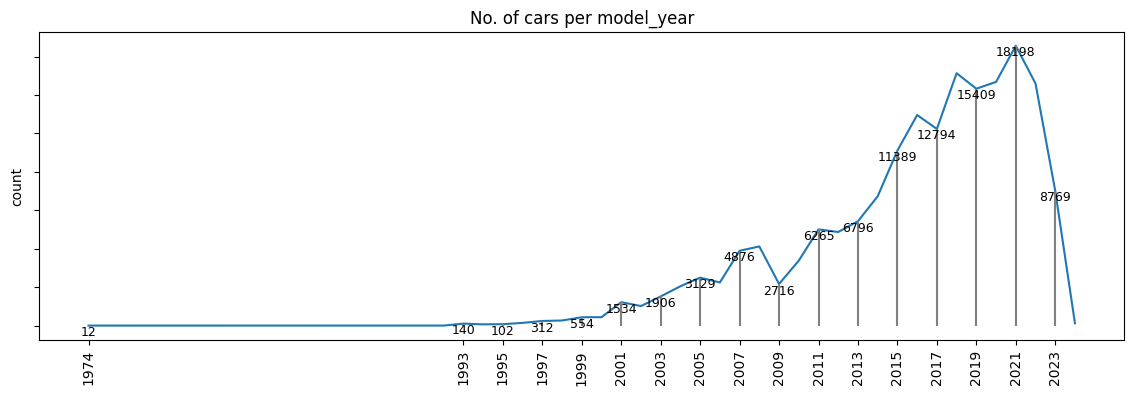

In [8]:
plt.figure(figsize=(14, 4))

# Get the value counts of 'model_year' and sort by index
yvc = df.model_year.value_counts().sort_index()

# Create a line plot
yr = sns.lineplot(x=list(yvc.index), y=yvc)

# Adjust the x-axis ticks, rotating every second year for readability
plt.xticks(list(yvc.index)[::2], rotation=90)

# Add vertical lines and text labels to the plot
for i in range(0, len(yvc), 2):
    yr.vlines(x=yvc.index[i], ymin=0, ymax=yvc.values[i], colors='grey')
    yr.text(yvc.index[i], yvc.values[i], f"{yvc.values[i]}", ha='center', va="top", fontsize=9)

# Set the title
plt.title("No. of cars per model_year")

# Optionally hide y-axis tick labels
yr.set_yticklabels([])

# Show the plot
plt.show()

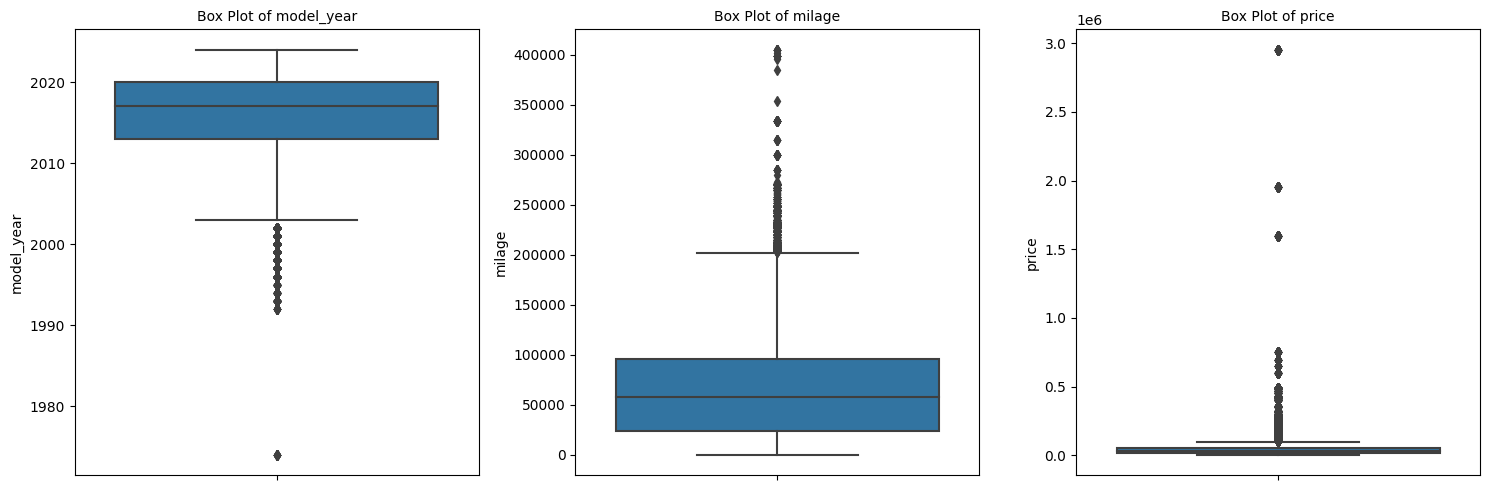

In [9]:
# lets do boxplot to identify outliers
# Creating grid of subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax = ax.flatten()
# Loop through columns and plot box plots
for idx, col in enumerate(cont_col):
    sns.boxplot(data=df, y=col, ax=ax[idx])
    ax[idx].set_title(f'Box Plot of {col}', fontsize=10)
    ax[idx].set_ylabel(col)

# Hide the empty subplot
if len(cont_col) < len(ax):
    ax[len(cont_col)].set_visible(False)
    
# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

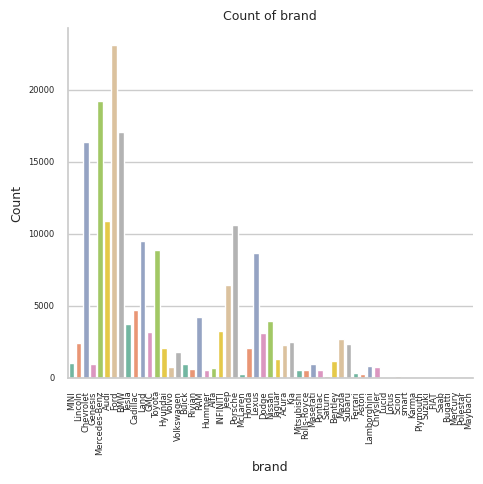

<Figure size 1200x600 with 0 Axes>

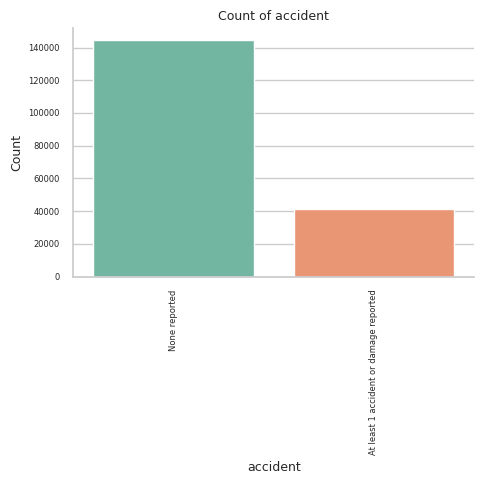

<Figure size 1200x600 with 0 Axes>

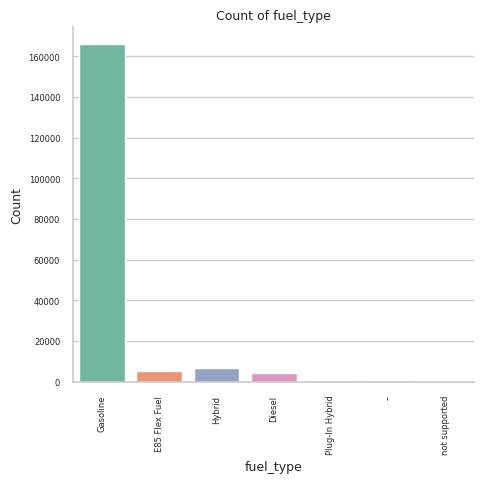

In [10]:
# check the occurences of each brand in 'brand' feature
# df['fuel_type'].value_counts()
#df[df['fuel_type'] == '–']

for i in ['brand', 'accident', 'fuel_type']:
    # set Seaborn theme 
    sns.set_theme(style="whitegrid")

    # create the plot with custom colors
    plt.figure(figsize=(12, 6))  
    sns.catplot(x= i, data=df, kind='count', palette='Set2')
    plt.title(f'Count of {i}', fontsize=9)
    plt.xlabel(f'{i}', fontsize=9)
    plt.ylabel('Count', fontsize=9)
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6, rotation=90)
    sns.despine()
    plt.tight_layout()
    plt.show()

Gasoline has the highest count of fuel type, and there are also '-' and 'not supported' variables in the fuel_type feature.

### Multivariate Analysis

In [11]:
def plot_facetgrid(hue, x_axis):
    '''density plot and differentiate with another feature '''
    fig = sns.FacetGrid(df,hue=hue,aspect=3)
    fig.map(sns.kdeplot, x_axis, fill=True)
    oldest = df[x_axis].max()
    fig.set(xlim=(0,oldest))
    fig.add_legend()
    fig.fig.suptitle(f'Distribution of {x_axis} by {hue}')
# x_axis numerical, hue categorical

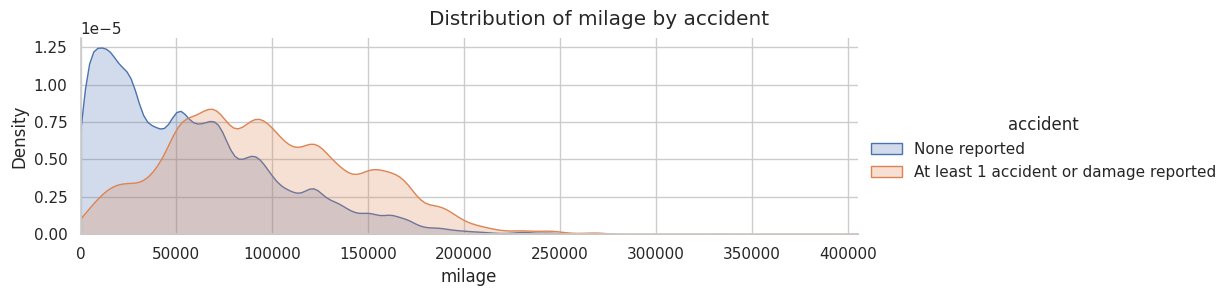

In [12]:
plot_facetgrid('accident', 'milage')

Lower mileage is associated with no accidents reported, while higher mileage has higher density of least one accident or damage reported.

In [13]:
def plot_scatter(feature_x, feature_y):
# for i in ['model_year', 'milage']:
    plt.figure(figsize=(6, 3))
    sns.scatterplot(data=df, x=feature_x, y=feature_y, s =20)
    # Set title and axis labels
    plt.title(f'{feature_x} vs {feature_y}', fontsize=9)
    plt.xlabel(f'{feature_x}', fontsize=8)
    plt.ylabel(f'{feature_y}', fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

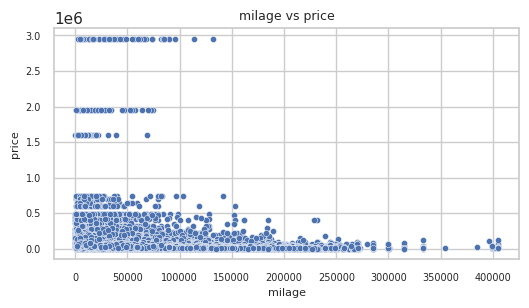

In [14]:
# plot milage
plot_scatter('milage', 'price')

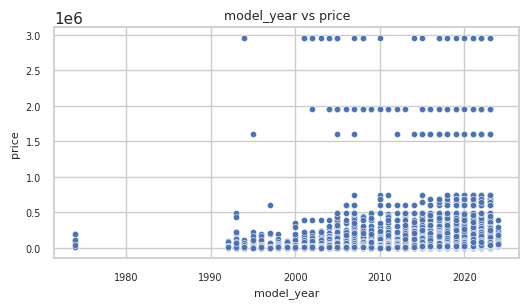

In [15]:
plot_scatter('model_year', 'price')

We dont really see any linear relationship between price & milage, price & model_year

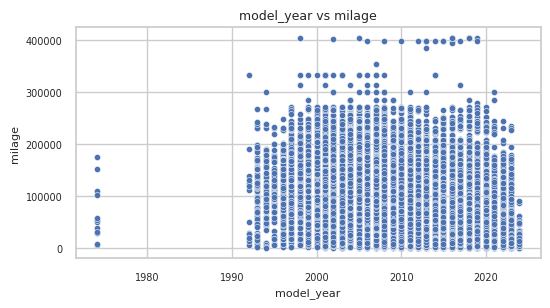

In [16]:
plot_scatter('model_year', 'milage')

Similarly, no linear relationship between model_year and milage

# 5. Data Preprocessing

## Feature extraction from 'engine'
There are some information that we can extract from 'engine' and we can use that to impute into the missing values in fuel_type feature. Let's see the unique values in engine where the fuel_type is na.

In [17]:
df.engine.value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [18]:
# see the unique values in fuel_type
df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [19]:
# change the '–' into missing values then we will impute it with whatever values extracted from engine
df['fuel_type'] = df['fuel_type'].replace('–', np.nan)
df['fuel_type'] = df['fuel_type'].replace('not supported', np.nan)

# apply to df used for submission later
df_sub['fuel_type'] = df_sub['fuel_type'].replace('–', np.nan)
df_sub['fuel_type'] = df_sub['fuel_type'].replace('not supported', np.nan)

In [20]:
def extract_engine(s: str):
    
    # Extract fuel type
    fuel_types = ['Gasoline', 'Diesel', 'Electric', 'Hybrid', 'Flex Fuel']
    fuel_ext = next((fuel for fuel in fuel_types if fuel in s), np.nan)  # Return the first matching fuel type, or an empty string

    # Extract horsepower
    hpgroup = re.search(r'(\d+(\.\d+)?)\s*hp', s, re.IGNORECASE)
    engine_hp = float(hpgroup.group(1)) if hpgroup else np.nan
    
    # Extract liters (L or Liter)
    litergroup = re.search(r'(\d+(\.\d+)?)\s*[Ll](?:iter)?', s, re.IGNORECASE)
    engine_liter = float(litergroup.group(1)) if litergroup else np.nan
    
    # Extract cylinder count
    cylindergroup = re.search(r'(\d+)\s*cylinders?|([ivxlcdm]+)\s*cylinders?', s, re.IGNORECASE)
    if cylindergroup:
        engine_cyl = int(cylindergroup.group(1)) if cylindergroup.group(1) else cylindergroup.group(2).upper()
    else:
        engine_cyl = np.nan
    
    
    return engine_hp, engine_liter, engine_cyl, fuel_ext
 

df[['engine_hp','engine_liter','engine_cyl','engine_fuel']]=df['engine'].apply(extract_engine).apply(pd.Series)

df_sub[['engine_hp','engine_liter','engine_cyl','engine_fuel']]=df_sub['engine'].apply(extract_engine).apply(pd.Series)

There are some input in engine where there is only '3.0L' information available. 
So we can retrieve the fuel type from the extracted fuel from the engine if the row fuel is missing, but do not delete the original fuel_type column. <br>

In [21]:
# replace the missing values in fuel_type column with the extracted fuel from engine 'engine_fuel'
df['fuel_type'] = df['fuel_type'].fillna(df['engine_fuel'])

df_sub['fuel_type'] = df_sub['fuel_type'].fillna(df_sub['engine_fuel'])

# check again for sanity
aggregate_info(df)


,nunique values,unique,missing_count,missing_percentage,dtypes
id,188533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.00,int64
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
model_year,34,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",0,0.00,int64
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,7,"[Gasoline, E85 Flex Fuel, Electric, Hybrid, Di...",951,0.50,object
engine,1117,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",0,0.00,object
transmission,52,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",0,0.00,object
ext_col,319,"[Yellow, Silver, Blue, Black, White, Snowflake...",0,0.00,object
int_col,156,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",0,0.00,object


Seems like we had managed to reduce the number of missing values in fuel_type to 0.50% only.

In [22]:
# see the unique values in fuel_type
df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electric', 'Hybrid', 'Diesel', nan,
       'Plug-In Hybrid', 'Flex Fuel'], dtype=object)

In [23]:
# see the unique values in fuel_type
df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electric', 'Hybrid', 'Diesel', nan,
       'Plug-In Hybrid', 'Flex Fuel'], dtype=object)

After creating new features, it is better to convert the 'E85 Flex Fuel' to 'Flex Fuel' in the fuel_type feature. 

In [24]:
df['fuel_type'] = df['fuel_type'].replace('E85 Flex Fuel', 'Flex Fuel')
df.fuel_type.unique()

df_sub['fuel_type'] = df_sub['fuel_type'].replace('E85 Flex Fuel', 'Flex Fuel')

## Feature extration from 'Transmission'

From this feature, we can extract the types of transmission and types of gear

In [25]:
df.transmission.value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [26]:
def extract_transmission(s:str):    
    # extract speed
    speedgroup = re.search(r'(\d+)', s)
    speed = int(speedgroup.group(1)) if speedgroup else np.nan
    
    # search for automatic
    if re.search(r'(automatic | at | a/t)', s, re.IGNORECASE):
        gear = 'Automatic'
    elif re.search(r'(manual | mt | m/t)', s, re.IGNORECASE):
        gear = 'Manual'
    elif re.search(r'(dual|at/mt)', s, re.IGNORECASE):
        gear = 'Dual'
    elif re.search(r'(cvt)', s, re.IGNORECASE):
        gear = 'CVT'
    else:
        gear = 'other'
    
    return speed, gear

# apply the function
df[['speed', 'gear']] = df['transmission'].apply(extract_transmission).apply(pd.Series)

df_sub[['speed', 'gear']] = df_sub['transmission'].apply(extract_transmission).apply(pd.Series)

## Create new feature 'car_age'
Create new feature car_age to better present longitivity of the car and to replace the model_year.

In [27]:
df['car_age'] = 2024-df['model_year']

df_sub['car_age'] = 2024-df_sub['model_year']

## Simplify the Exterior & Interior Color
The Colors column contains many unique values, as it includes different shades of the same primary color, such as "Jet Black" and "Black." We will simplify the values by standardize by coverting it to base colors. If a color name contains one of these base colors, it will be converted to that base color; otherwise, it will be categorized as "uncommon.

In [28]:
df.ext_col.value_counts()

ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

In [29]:
def transform_basecolor(s: str):
    s = s.lower()
    base_colors = ['white', 'black', 'grey', 'gray', 'blue', 'red', 'yellow', 'silver', 'green', 'beige', 'gold', 'orange', 'brown', 'ebony', 'purple']
    
    # Find the first matching base color
    color = next((i for i in base_colors if i in s), 'uncommon')
    
    # Replace 'grey' with 'gray'
    if color == 'grey': 
        color = 'gray'
    
    return color


# apply to both ext_col and int_col
df['ext_col']=df['ext_col'].apply(transform_basecolor)
df['int_col']=df['int_col'].apply(transform_basecolor)

# df.int_col.value_counts()
   
df_sub['ext_col']=df_sub['ext_col'].apply(transform_basecolor)
df_sub['int_col']=df_sub['int_col'].apply(transform_basecolor)

By doing this, we manage to reduce the distinct categories of both features <br>
* ext_col from 319 to 15 <br>
* int_col from 156 to 14 <br>

## Handling skewed data distribution
From EDA previously we can see our numerical features have skewed distribution. <br>
Handling skewed data distribution is essential in machine learning and data analysis, as the algorithms perform better when the data is normally distributed or close to
Let's manage the target price by applying log transformation.

Skewness before transformation: 20.268291451403694


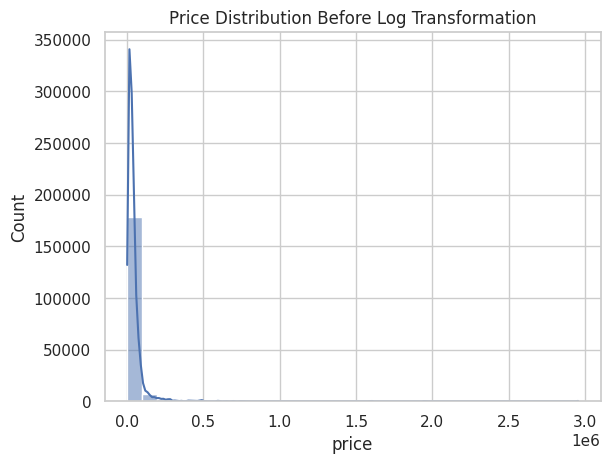

Skewness after log transformation: 0.10773086009455625


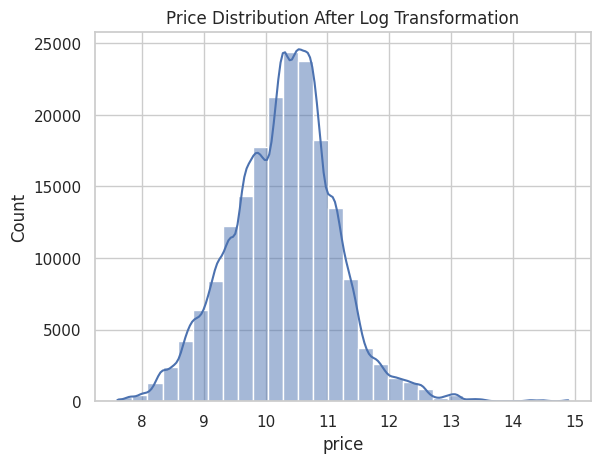

In [30]:
# Check skewness of price before transformation
print(f"Skewness before transformation: {skew(df['price'])}")
# Plot the distribution before log transformation
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Price Distribution Before Log Transformation")
plt.show()

# Apply log transformation 
df['price'] = np.log(df['price'])  # log1p is used to avoid log(0)
# Check skewness after log transformation
print(f"Skewness after log transformation: {skew(df['price'])}")
# Plot the distribution after log transformation
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Price Distribution After Log Transformation")
plt.show()
# For normally distributed data, the skewness should be about zero. 


In [31]:
df.nunique()
# df.head(5)

id              188533
brand               57
model             1897
model_year          34
milage            6651
fuel_type            6
engine            1117
transmission        52
ext_col             15
int_col             14
accident             2
clean_title          1
price             1569
engine_hp          348
engine_liter        61
engine_cyl           7
engine_fuel          5
speed                9
gear                 5
car_age             34
dtype: int64

## Remove redundant features
We going to remove the feature 'id', 'engine', 'transmission', 'model_year' as they could be redundant and become noise for the model. <br>

In [32]:
# drop features
df = df.drop(columns=['id', 'engine', 'transmission', 'engine_fuel', 'model_year'])
df.head(5)


df_sub = df_sub.drop(columns=['id', 'engine', 'transmission', 'engine_fuel', 'model_year'])

## Handling missing values

In [33]:
aggregate_info(df)

,nunique values,unique,missing_count,missing_percentage,dtypes
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,6,"[Gasoline, Flex Fuel, Electric, Hybrid, Diesel...",951,0.50,object
ext_col,15,"[yellow, silver, blue, black, white, gray, gre...",0,0.00,object
int_col,14,"[gray, beige, black, uncommon, blue, white, re...",0,0.00,object
accident,2,"[None reported, At least 1 accident or damage ...",2452,1.30,object
clean_title,1,"[Yes, nan]",21419,11.36,object
price,1569,"[8.34283980427146, 8.51699317141357, 9.5396441...",0,0.00,float64
engine_hp,348,"[172.0, 252.0, 320.0, 420.0, 208.0, 333.0, 355...",33259,17.64,float64


### Imputing missing values in the new features
We have created new features by extracting from 'engine' and 'transmission', and these features have nan in them. Thanks to this [notebook](https://www.kaggle.com/code/avinandanpal/price-prediction-of-used-cars?scriptVersionId=197975473&cellId=94), below function fills missing values in a column (target_cols) based on the most frequent value in the same brand and model group. If the combination of brand and model doesn't have a mode, it falls back to using the mode of the brand alone.

In [34]:
def fill_na_with_same_brand_model_mode(df, grouping_cols, target_cols):
    
    # Mode Calculator
    def calculate_mode(series):
        mode = series.mode()
        return mode.iloc[0] if not mode.empty else np.nan
    
    # NA filler function
    def impute_na(row):
        if pd.notna(row[col]):
            return row[col]
        if pd.notna(row['brand_model_mode']):
            return row['brand_model_mode']
        if pd.notna(row['brand_mode']):
            return row['brand_mode']

        return row[col]
    
    #-------------
    for col in target_cols:
        # find mode of same brand & model
        brand_model_mode = df.groupby(grouping_cols)[col].apply(calculate_mode).rename("brand_model_mode")
        
        # find mode of same brand
        brand_mode = df.groupby(grouping_cols[0])[col].apply(calculate_mode).rename("brand_mode")
        
        #merging the series to have corresponding mode for each brand & band_model combo in each rows
        df = df.merge(brand_model_mode, on=grouping_cols, how='left')
        df = df.merge(brand_mode, on=grouping_cols[0], how='left')
        
        #applying na_filler function
        df[col] = df.apply(impute_na, axis=1)
        
        #deleting newly added cols
        df.drop(columns=['brand_model_mode','brand_mode'],inplace=True)
    
    return df

In [35]:
df = fill_na_with_same_brand_model_mode(df, ['brand','model'], ['speed','engine_hp','engine_liter','engine_cyl', 'fuel_type'])

df_sub = fill_na_with_same_brand_model_mode(df_sub, ['brand','model'], ['speed','engine_hp','engine_liter','engine_cyl', 'fuel_type'])

### Handling missing values in clean_title and accident

We will first impute the feature clean_title based on accident values. It makes sense to impute the clean_title as 'Yes' if there is no accident reported and 'No' if there is accident reported. The value of none reported and a clean title car are also higher than the other.

In [36]:
df[['accident','clean_title']].value_counts()

accident                                clean_title
None reported                           Yes            126687
At least 1 accident or damage reported  Yes             40413
Name: count, dtype: int64

In [37]:
def fill_clean_title(row):
    if pd.isna(row['clean_title']):
        if row['accident'] == 'None reported':
            return "Yes"
        elif row['accident'] == 'At least 1 accident or damage reported':
            return "No"
    return row['clean_title']

# Apply the function row by row using axis=1
df['clean_title'] = df.apply(fill_clean_title, axis=1)

df_sub['clean_title'] = df_sub.apply(fill_clean_title, axis=1)

In [38]:
aggregate_info(df)

,nunique values,unique,missing_count,missing_percentage,dtypes
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,6,"[Gasoline, Flex Fuel, Electric, Hybrid, Diesel...",0,0.00,object
ext_col,15,"[yellow, silver, blue, black, white, gray, gre...",0,0.00,object
int_col,14,"[gray, beige, black, uncommon, blue, white, re...",0,0.00,object
accident,2,"[None reported, At least 1 accident or damage ...",2452,1.30,object
clean_title,2,"[Yes, No, nan]",2438,1.29,object
price,1569,"[8.34283980427146, 8.51699317141357, 9.5396441...",0,0.00,float64
engine_hp,348,"[172.0, 252.0, 320.0, 420.0, 208.0, 333.0, 355...",7,0.00,float64


In [39]:
# Fill 'engine_cyl' NaN values with mode
mode_engine_cyl = df['engine_cyl'].mode()[0]  # Get the mode (most frequent value)
df['engine_cyl'] = df['engine_cyl'].fillna(mode_engine_cyl)

# Fill 'engine_hp' NaN values with mode
mode_engine_hp = df['engine_hp'].mode()[0]  # Get the mode (most frequent value)
df['engine_hp'] = df['engine_hp'].fillna(mode_engine_hp)

# Similarly for df_sub
mode_engine_cyl_sub = df_sub['engine_cyl'].mode()[0]
df_sub['engine_cyl'] = df_sub['engine_cyl'].fillna(mode_engine_cyl_sub)

mode_engine_hp_sub = df_sub['engine_hp'].mode()[0]
df_sub['engine_hp'] = df_sub['engine_hp'].fillna(mode_engine_hp_sub)

## Handling outliers
For now we are just going to remove the outliers in the feature milage. 
Sometime the outliers represent actual, meaningful data points (for example luxury cars with very high prices), they shouldn't be removed, as these represent important variations in the data.

In [40]:
def handling_outliers(data, feature):
    ''' calculate percent of outliers and remove them'''
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df_outliers = data[(data[feature] <= lower) | (data[feature] >= upper)]
    
    percent_outlier = round(len(df_outliers)/len(data)*100,4)
    # print(df_outliers[feature].value_counts())
    print('Percentage of outliers:',percent_outlier)
    df_cleaned = data[(data[feature] >= lower) & (data[feature] <= upper)]
    return df_cleaned
    

df_cleaned = handling_outliers(df, 'milage')

Percentage of outliers: 0.9367


In [41]:
df_cleaned.head(3)

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,speed,gear,car_age
1,Lincoln,LS V8,143250,Gasoline,silver,beige,At least 1 accident or damage reported,Yes,8.516993,252.0,3.9,8.0,5.0,other,22
2,Chevrolet,Silverado 2500 LT,136731,Flex Fuel,blue,gray,None reported,Yes,9.539644,320.0,5.3,8.0,6.0,other,22
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,black,black,None reported,Yes,10.714418,420.0,5.0,8.0,8.0,Dual,7


## Handling Categorical Features
### Label Encoding
Label categorical features with small distinct categories: <br>
int_col, ext_col, fuel_type, accident, clean_title,  gear

In [42]:
def label_encode_columns(df, columns):
    """ label encode specific columns """
    label_encoders = {}
    
    # Loop through each column, fit the label encoder, and transform the column
    for col in columns:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
        #label_encoders[col] = label_encoder  # Store the encoders if you need them later
    
    return df


# apply function
columns_to_encode = ['int_col', 'ext_col', 'fuel_type', 'accident', 'clean_title', 'gear']
df_cleaned = label_encode_columns(df_cleaned, columns_to_encode)

df_sub = label_encode_columns(df_sub, columns_to_encode)

In [43]:
df_cleaned.head(3)

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,speed,gear,car_age
1,Lincoln,LS V8,143250,3,11,0,0,1,8.516993,252.0,3.9,8.0,5.0,4,22
2,Chevrolet,Silverado 2500 LT,136731,2,2,6,1,1,9.539644,320.0,5.3,8.0,6.0,4,22
3,Genesis,G90 5.0 Ultimate,19500,3,1,1,1,1,10.714418,420.0,5.0,8.0,8.0,2,7


### Target Enconding
Target encoding will be used on 'brand' and 'model' as these features have high number of distinct categories. In cases with high cardinal features, target encoding is a better option. <br>

The mean target encoding for each category in the feature label is decided with the mean value of the target variable on a training data. For Regression problems, the expected value is simply the average value for that category. <br>

To avoid target leakage into the test set, its best to encode the features after we have split the dataset into train and test

In [44]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

print(f'Training set size: {train_df.shape}')
print(f'Testing set size: {test_df.shape}')

Training set size: (149413, 15)
Testing set size: (37354, 15)


In [45]:
# Apply target encoder to brand
brand_encoder = TargetEncoder()

# Fit the encoder for feaeture brand to the training set and apply to test set
train_df['brand'] = brand_encoder.fit_transform(train_df['brand'], train_df['price'])
test_df['brand'] = brand_encoder.transform(test_df['brand'])

# Apply target encoder to brand and model
model_encoder = TargetEncoder()
# Fit the encoder for feaeture model to the training set and apply to test set
train_df['model'] = model_encoder.fit_transform(train_df['model'], train_df['price'])
test_df['model'] = model_encoder.transform(test_df['model'])

# apply to df_sub
df_sub['brand'] = brand_encoder.transform(df_sub['brand'])
df_sub['model'] = model_encoder.transform(df_sub['model'])

In [46]:
aggregate_info(train_df)

,nunique values,unique,missing_count,missing_percentage,dtypes
brand,57,"[10.352071942837046, 9.956171774704442, 10.312...",0,0.0,float64
model,1897,"[10.711361341324105, 9.852561816833296, 10.055...",0,0.0,float64
milage,5981,"[27965, 193827, 84000, 49131, 55000, 2838, 900...",0,0.0,int64
fuel_type,6,"[3, 1, 4, 0, 2, 5]",0,0.0,int64
ext_col,15,"[7, 6, 2, 1, 13, 10, 11, 12, 8, 14, 5, 0, 4, 3...",0,0.0,int64
int_col,14,"[1, 6, 0, 9, 12, 11, 8, 3, 4, 2, 13, 10, 7, 5]",0,0.0,int64
accident,3,"[1, 0, 2]",0,0.0,int64
clean_title,3,"[1, 2, 0]",0,0.0,int64
price,1569,"[11.125791313546788, 9.116029692504942, 10.199...",0,0.0,float64
engine_hp,348,"[560.0, 159.0, 292.0, 375.0, 340.0, 521.0, 301...",0,0.0,float64


In [47]:
train_df.head(3)

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,speed,gear,car_age
849,10.352072,10.711361,27965,3,7,1,1,1,11.125791,560.0,4.4,8.0,7.0,2,8
66590,9.956172,9.852562,193827,3,6,6,1,1,9.116030,159.0,2.7,4.0,6.0,4,16
82350,10.312885,10.055268,84000,3,2,1,0,1,10.199882,292.0,2.0,4.0,6.0,0,6


## Split target and features

In [48]:
# define target (y) and features (X)
# separate the target price
y_train = train_df['price']
# get x by dropping column price from df
x_train = train_df.drop(columns=['price'])

# apply the same to test set
y_test = test_df['price']
x_test = test_df.drop(columns=['price'])

# inverse the y_test
y_test = np.exp(y_test)

In [49]:
# from sklearn.preprocessing import MinMaxScaler
# # Normalize the dataset
# scaler = MinMaxScaler()

# x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
# x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)
# # df_sub = pd.DataFrame(scaler.fit_transform(df_sub), columns=df_sub.columns)

In [50]:
train_df.head(3)

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,speed,gear,car_age
849,10.352072,10.711361,27965,3,7,1,1,1,11.125791,560.0,4.4,8.0,7.0,2,8
66590,9.956172,9.852562,193827,3,6,6,1,1,9.116030,159.0,2.7,4.0,6.0,4,16
82350,10.312885,10.055268,84000,3,2,1,0,1,10.199882,292.0,2.0,4.0,6.0,0,6


In [51]:
x_train.head(3)

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,engine_hp,engine_liter,engine_cyl,speed,gear,car_age
849,10.352072,10.711361,27965,3,7,1,1,1,560.0,4.4,8.0,7.0,2,8
66590,9.956172,9.852562,193827,3,6,6,1,1,159.0,2.7,4.0,6.0,4,16
82350,10.312885,10.055268,84000,3,2,1,0,1,292.0,2.0,4.0,6.0,0,6


# 7. Feature Selection


Now that we have cleaned our data and all the features are in continuous forms, we can proceed with selecting with features would be important for the model. First I would like to do a correlation analysis so we can see if there is any multicollinearity among the features.

## Correlation Analysis

Top related features:           Feature1    Feature2  Correlation             sorted_features
161  engine_liter  engine_cyl     0.831949  (engine_cyl, engine_liter)
122         price      milage     0.704597             (milage, price)
24          model   engine_hp     0.691961          (engine_hp, model)
212       car_age      milage     0.668403           (car_age, milage)
23          model       price     0.659625              (model, price)
218       car_age       price     0.659081            (car_age, price)
146     engine_hp  engine_cyl     0.648280     (engine_cyl, engine_hp)
29          model     car_age     0.641962            (car_age, model)
31         milage       model     0.607209             (milage, model)
159  engine_liter   engine_hp     0.580917   (engine_hp, engine_liter)


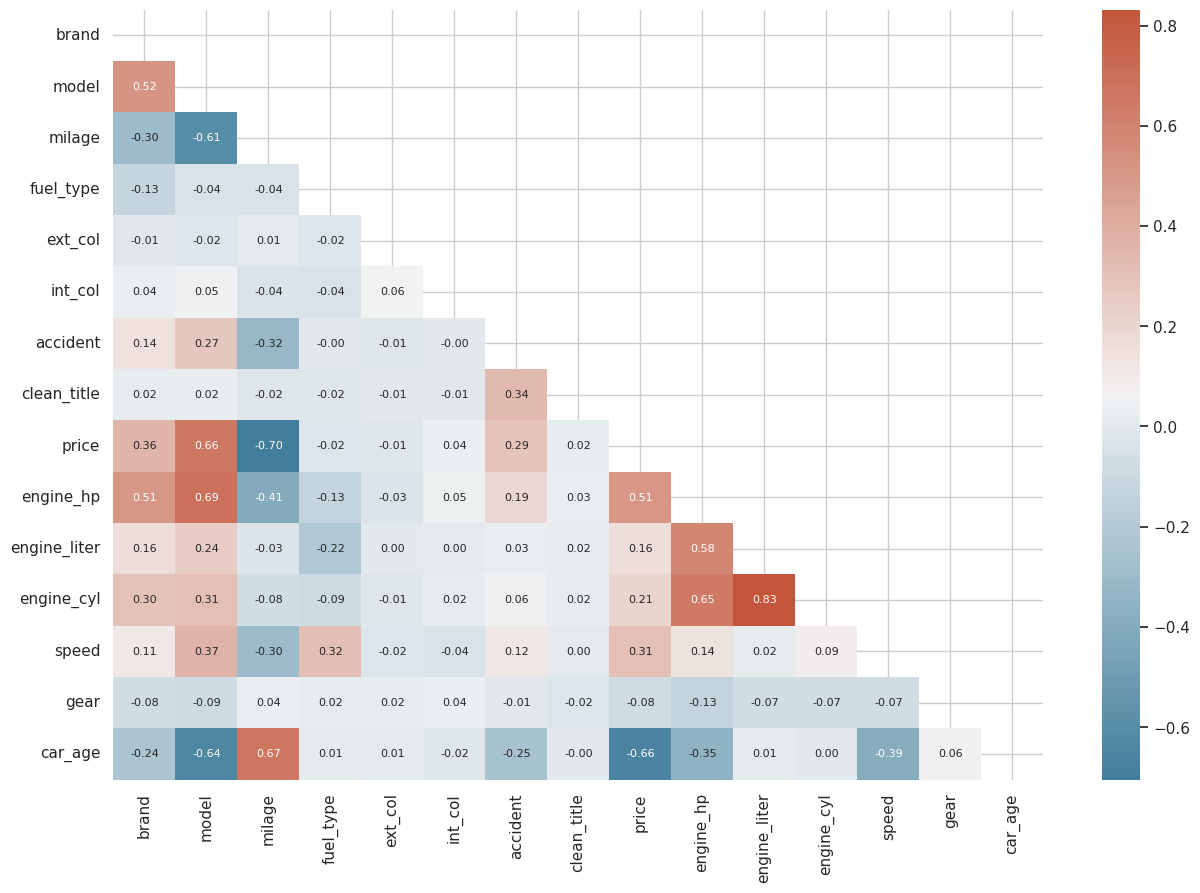

In [52]:
def correlation_analysis(df):
    ''' visualise the correlation matrix,
    and return the highest correlated pairs'''

    # Correlation matrix
    df_num = df.select_dtypes(include=[np.number])

    # Compute the correlation matrix
    corr = df_num.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                fmt='.2f', cbar=True, annot_kws={"size": 8})

    # unstack the matrix
    corr_unstacked = corr.unstack()

    # Convert the Series to a DataFrame and reset the index
    corr_df = pd.DataFrame(corr_unstacked).reset_index()
    corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

    # Remove self-correlations (correlation of a feature with itself)
    corr_df = corr_df[corr_df['Feature1'] != corr_df['Feature2']]

    # Get the absolute values of the correlations
    corr_df['Correlation'] = corr_df['Correlation'].abs()

    # Sort the DataFrame by absolute correlation values in descending order
    corr_df = corr_df.sort_values(by='Correlation', ascending=False)

    corr_df['sorted_features'] = corr_df.apply(lambda row: tuple(
        sorted([row['Feature1'], row['Feature2']])), axis=1)
    corr_df = corr_df.drop_duplicates(subset=['sorted_features'])

    # Extract the top 10 related features
    top_related = corr_df.head(10)

    return top_related


# top_correlated = correlation_analysis(df)
top_correlated = correlation_analysis(train_df)

print('Top related features: ', top_correlated)

Engine_liter and engine_cyl is highly correlated. One of it will be dropped later. <br>
Milage is highly correlated with price. As milage increases, the price decreases which makes sense.

## Mutual Info Regression

In [53]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(x_train, y_train)


mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)


milage          0.631436
car_age         0.537321
model           0.432234
engine_hp       0.385166
speed           0.209657
engine_liter    0.172833
brand           0.152824
gear            0.097800
int_col         0.086632
accident        0.062304
ext_col         0.061572
engine_cyl      0.046086
fuel_type       0.030816
clean_title     0.010092
dtype: float64

<Axes: >

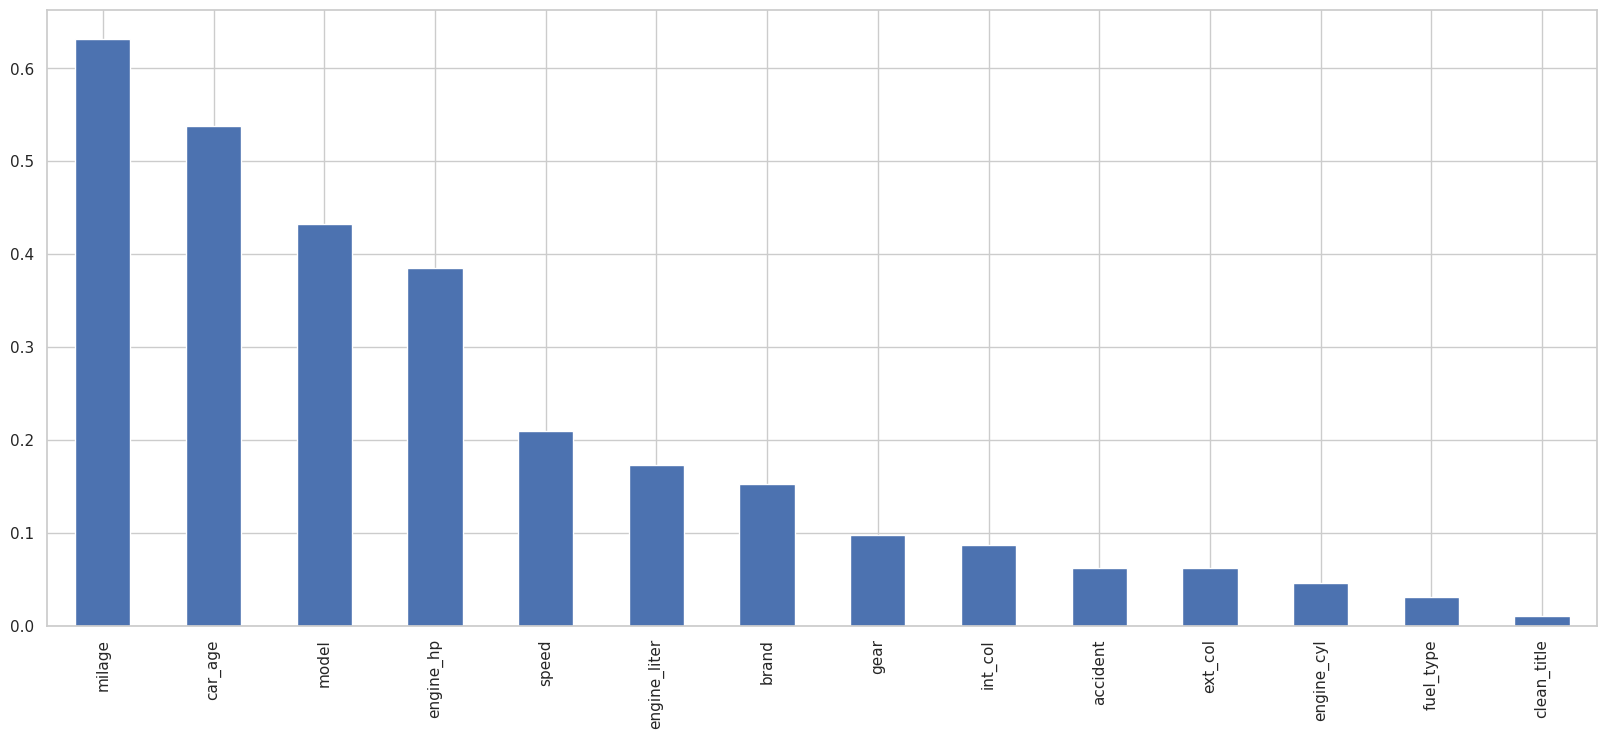

In [54]:
# visualise the values
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

From the graph, we can infer that the milage are having the highest mutual information gain(0.63) then car_age 0.54 followed by model(0.43), and so on. So milage give 63% of the information about the target variable price in this case, which we can see in the previous correlation analysis it is highly correlated with price.

In [55]:
# drop high correlated feature
x_train = x_train.drop(columns=['engine_cyl', 'clean_title'])
x_test = x_test.drop(columns=['engine_cyl', 'clean_title'])
df_sub = df_sub.drop(columns=['engine_cyl', 'clean_title'])

# 6. Building the Model 

Let's build a Multiple Linear Regression and use it as a baseline to compare with other machine learning model.
I'm also interested to see the difference of performance between bagging and boosting DT. So I will be building a base model and optimised RF, and then a XGBoost model, Catboost model. 

In [56]:
y_test

24305      84000.0
29975      20499.0
83223      24325.0
97696      15000.0
184925    104900.0
            ...   
129817    128995.0
105759     60995.0
149958     11000.0
95609     188500.0
159025     20999.0
Name: price, Length: 37354, dtype: float64

## Multiple Linear Regression

In [57]:
def evaluate_model(y_test, y_pred):
    ''' function to evaluate rmse, mae and rsquared'''
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate R-squared (R²)
    r_squared = r2_score(y_test, y_pred)
    
    # Print the evaluation metrics
    print(f'RMSE: {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R²): {r_squared}')
    
    return rmse, mae, r_squared

In [58]:
from sklearn.linear_model import LinearRegression

# initialize model
linear_model = LinearRegression()

# fit model
linear_model.fit(x_train,y_train)

# make prediction
linear_pred = linear_model.predict(x_test)

# inverse the log
linear_pred = np.exp(linear_pred )
print(linear_pred)


linear_rmse, linear_mae, linear_rsquared = evaluate_model(y_test, linear_pred)

# all feature RMSE: 63654.210945813014

#without engine_cyl & clean_title RMSE: 63722.400514590656


[41592.25927063 21191.05328948 31505.68373144 ... 19781.65161583
 61872.91199618 27006.70697075]
RMSE: 63722.400514590656
Mean Absolute Error (MAE): 17374.734548092227
R-squared (R²): 0.1387889672881295


In [59]:
linear_model.coef_

array([ 1.13587772e-01,  2.30618637e-01, -6.62241653e-06, -4.91349952e-03,
       -5.01174013e-04,  3.04228866e-03,  7.41053519e-02,  8.05470833e-04,
        2.54254140e-02,  1.01860759e-02, -9.66314464e-03, -3.74343323e-02])

## Random Forest
I like to build the base model first, and then optimised it just so I can see the improvements. For hyperparameter tuning, I opted for gridsearch since the dataset size is manageable. 

### Base Random Forest

In [60]:
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)

# making predictions
rf_pred = rf.predict(x_test)

# inverse the log
rf_pred = np.exp(rf_pred)

rf_rmse, rf_mae, rf_rsquared = evaluate_model(y_test, rf_pred)

# all feature RMSE: 63151.27743696632

#without engine_cyl & clean_title RMSE: 63155.06377260905

RMSE: 63155.06377260905
Mean Absolute Error (MAE): 17233.673233489375
R-squared (R²): 0.1540558626763847


### Hyperparameter Tune the Random Forest model

In [61]:
# Define a reduced parameter grid
# param_dist_rf = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }

# # Initialize the model
# random_forest = RandomForestRegressor(random_state=42)

# # Random search over the parameter grid with parallel processing
# random_search_rf = RandomizedSearchCV(
#     estimator=random_forest,
#     param_distributions=param_dist_rf,
#     n_iter=10,  # Reduced number of iterations
#     scoring='neg_mean_squared_error',
#     cv=3,  # Consider reducing cross-validation folds
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# # Fit the model
# random_search_rf.fit(x_train, y_train)
# best_params_rf = random_search_rf.best_params_
# print("Best Parameters for Random Forest:", best_params_rf)


In [62]:
tuned_rf = RandomForestRegressor(n_estimators=500,
                                 min_samples_split = 5,
                                 max_features = 'sqrt',
                                 max_depth=20, 
                                 min_samples_leaf=1,
                                bootstrap = True)

tuned_rf.fit(x_train, y_train) 
tuned_rf_pred = tuned_rf.predict(x_test) 


# inverse the log
tuned_rf_pred = np.exp(tuned_rf_pred)

tuned_rf_rmse, tuned_rf_mae, tuned_rf_rsquared = evaluate_model(y_test, tuned_rf_pred)


#optuna RMSE: 63173.59102936626
#randomsearch 
##all faeturs: RMSE: 62667.439179263165
#without engine_cyl RMSE: 62678.10431768662
#without engine_cyl & clean_title RMSE: 62665.71158041151


RMSE: 62660.37551452348
Mean Absolute Error (MAE): 16461.521624837857
R-squared (R²): 0.16725637750498012


### Feature Importance

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

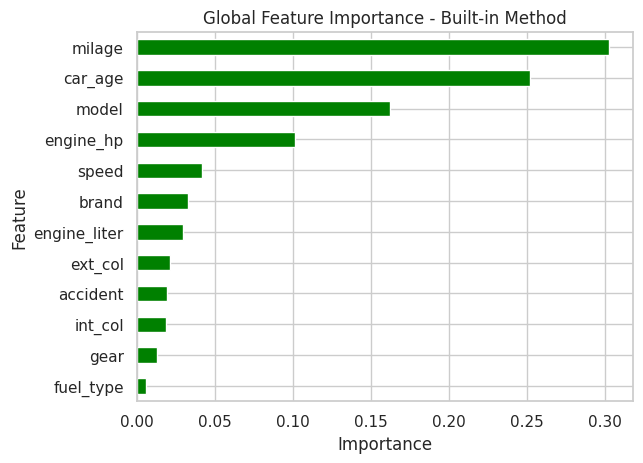

In [63]:
global_importances = pd.Series(tuned_rf.feature_importances_, index=x_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

## XGBoost

In [64]:
import xgboost as xgb

xgb_params={
     'lambda': 0.03880258557285165,
     'alpha': 0.02129832295514386,
     'colsample_bytree': 0.4,
     'subsample': 0.7,
     'learning_rate': 0.014,
     'max_depth': 17,
     'random_state': 2020,
     'min_child_weight': 85,
     'n_estimators': 10000
}


# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(**xgb_params)

# Train the model with early stopping
xgb_model.fit(
    x_train,
    y_train,
    eval_set=[(x_test, y_test)],
    early_stopping_rounds=100,
    verbose=200
)



[0]	validation_0-rmse:81047.79349
[200]	validation_0-rmse:81047.60402
[400]	validation_0-rmse:81047.58095
[600]	validation_0-rmse:81047.57635
[800]	validation_0-rmse:81047.57432
[1000]	validation_0-rmse:81047.57334
[1200]	validation_0-rmse:81047.57272
[1400]	validation_0-rmse:81047.57215
[1499]	validation_0-rmse:81047.57217


XGBRegressor(alpha=0.02129832295514386, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.03880258557285165,
             learning_rate=0.014, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
             max_leaves=None, min_child_weight=85, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, ...)

In [65]:
# Print the best iteration
print("Best iteration:", xgb_model.best_iteration)

# Use the underlying booster to predict on validation set using the best iteration
booster = xgb_model.get_booster()
xgb_pred = booster.predict(xgb.DMatrix(x_test), iteration_range=(0, xgb_model.best_iteration + 1))

# inverse the log
xgb_pred = np.exp(xgb_pred)

# evaluate model
xgb_rmse, xgb_mae, xgb_rsquared = evaluate_model(y_test, xgb_pred)


# RMSE: 62554.50620257583

Best iteration: 1399
RMSE: 62534.660064464464
Mean Absolute Error (MAE): 16428.44856020952
R-squared (R²): 0.17059449094491375


# Models perfomance comparison

### Compile and compare the result of these models

In [66]:
#create a DataFrame with rmse of the models
result_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Base RF', 'Tuned RF', 'XGB'],
    'RMSE': [linear_rmse, rf_rmse, tuned_rf_rmse, xgb_rmse],
    'MAE' : [linear_mae, rf_mae, tuned_rf_mae, xgb_mae],
    'R-squared' : [linear_rsquared, rf_rsquared, tuned_rf_rsquared, xgb_rsquared],
})

In [67]:
result_df 

,Model,RMSE,MAE,R-squared
0,Linear Regression,63722.400515,17374.734548,0.138789
1,Base RF,63155.063773,17233.673233,0.154056
2,Tuned RF,62660.375515,16461.521625,0.167256
3,XGB,62534.660064,16428.448560,0.170594


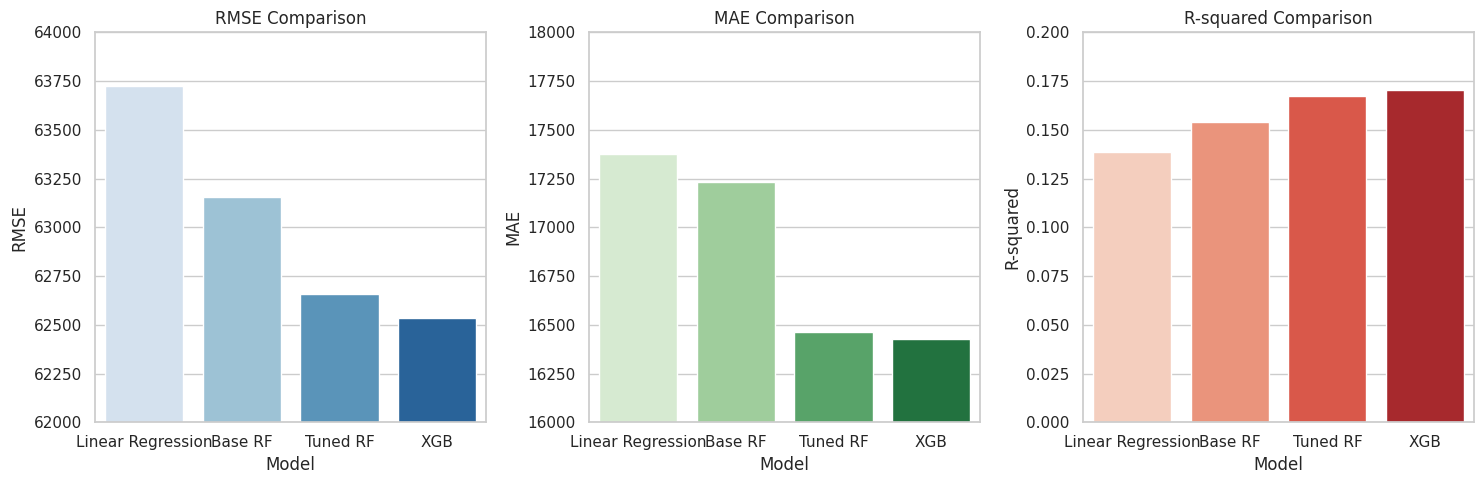

In [68]:

# Set the aesthetics for the plots
plt.figure(figsize=(15, 5))

# RMSE Plot
plt.subplot(1, 3, 1)
sns.barplot(data=result_df, x='Model', y='RMSE', palette='Blues')
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(62000, 64000)  # Adjust y-limit for visibility

# MAE Plot
plt.subplot(1, 3, 2)
sns.barplot(data=result_df, x='Model', y='MAE', palette='Greens')
plt.title('MAE Comparison')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.ylim(16000, 18000)  # Adjust y-limit for visibility

# R-squared Plot
plt.subplot(1, 3, 3)
sns.barplot(data=result_df, x='Model', y='R-squared', palette='Reds')
plt.title('R-squared Comparison')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.ylim(0, 0.2)  # Adjust y-limit for visibility

# Adjust layout
plt.tight_layout()
plt.show()

# 7. Submission

In [69]:
# make predictions
y_sub = booster.predict(xgb.DMatrix(df_sub), iteration_range=(0, xgb_model.best_iteration + 1))
y_sub = np.exp(y_sub)


# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'price': y_sub
})
submission

,id,price
0,188533,15097.708984
1,188534,73027.281250
2,188535,63384.183594
3,188536,23940.761719
4,188537,26618.648438
...,...,...
125685,314218,23439.716797
125686,314219,46440.613281
125687,314220,18887.548828
125688,314221,13319.856445


In [70]:
submission.to_csv("submission.csv", index=False)